In [1]:
import requests_cache
import requests
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from requests_oauthlib import OAuth1Session
import glob
import json
import os
import urllib2
from urllib2 import Request, urlopen
from requests_oauthlib import OAuth1Session
from bs4 import BeautifulSoup

### Data Wrangling Part 2 (From yelp dataset challenge):

In [ ]:
path = "/Users/Stephanie/Desktop/yelp_dataset_challenge_round9"
files = glob.glob(os.path.join(path,"*.json"))
files

In [ ]:
############# Copy from online(not sure if it works or not yet) ##########

#Convert Yelp Academic Dataset from JSON to CSV
import csv
def convert(line):
    ''' Convert a json string to a flat python dictionary
    which can be passed into Pandas. '''
    data = json.loads(line)
    for k, v in data.items():
        if isinstance(v, list):
            data[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                data['%s_%s' % (k, kk)] = vv
            del data[k]
    return line


csv_filename = 'review.csv'
df = pd.DataFrame([convert(line) for line in file(files[2])])
df.to_csv(csv_filename, index=False)


In [ ]:
def readfile(files):
    # read the file into a python array
    with open(files, 'rb') as f:
        data = f.readlines()
        # remove the trailing "\n" from each line
        data = map(lambda x: x.rstrip(), data)
        data_str = "[" + ','.join(data) + "]"
        df = pd.read_json(data_str)
        
        f.close()
        return df
     
def fixdf(newlist):
    new_df = pd.concat(newlist, axis = 0)
    return new_df

yelplist = []

In [ ]:
review_data = readfile(files[2])

In [ ]:
review_data.head()

### Data Wrangling 

In [2]:
import requests_cache
import requests
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from requests_oauthlib import OAuth1Session
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
requests_cache.install_cache("cache")

# criteria: 1=Distance, 2=Highest Rated

def yelp_search(term, location, criteria):
    """
    makes a search request
    
    Argument: search term, location
    
    Return: search result items as a list (for 0 items, return an empty list)
    """
    consumer_key = "uFKYftN0fu4pD6guW2cYng"
    consumer_secret = "iUYQ2Hk3-vTQVd0zOFnvloWPivA"
    token = "FZnep4FiFmwrrifuNm6M-_K661Wb3J02"
    token_secret = "CRvBo_fO-r4pE_-p2UrnN_mxBlc"
   
    urlbase = "http://api.yelp.com/v2/search"
    params = ({"term": term})
    
    criteria = criteria.lower()
    
    if criteria == "distance":
        params.update({"location": location, "sort": "1", "cll" : "latitude,longitude"})
    else:
        params.update({"location": location, "sort": "2", "cll" : "latitude,longitude"})
    session = OAuth1Session(consumer_key, consumer_secret,token,token_secret)
     
    request = session.get(urlbase,params=params)
   
    #Transforms JSON API response into dictionary
    data = request.json()
    session.close()
    output = data
    
    if "businesses" not in output:
        return {}
    
    else:
        return output["businesses"]


In [4]:
def extract(url):
    """
    extract
    """
    info = requests.get(url).content
    wikisoup = BeautifulSoup(info, 'lxml')
    city_data = wikisoup.findAll("th", {"scope": "row"})
    population_data = wikisoup.findAll("td", {"align":"right"})
    city = [city.text for city in city_data]
    city = city[1:-8]
    population_data = wikisoup.findAll("td", {"align":"right"})
    population_data = "\n".join([population.text for population in population_data])
    population_split = population_data.split("\n")
    population = population_split[0::2]
    info_dict = {"city": city, "population": population}
    return info_dict

In [5]:
url = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_California"
url_output = extract(url)
pd_scrape = pd.DataFrame(url_output)

In [6]:
# this excel provide latitude and longitude information
pd_location = pd.read_excel("/Users/Stephanie/Desktop/calcities.xlsx", header = 0)

In [7]:
pd_location_1 = pd_location.rename(columns = {'Name':'city'})
pd_geo = pd.merge(pd_scrape, pd_location_1, on = "city")

In [8]:
pd_geo['city'] = pd_geo['city'] + ', CA'

In [9]:
def search(keyterm, city, criteria):
    result = yelp_search(keyterm, city, criteria)
    df_result = pd.DataFrame(result)
    df_result["city"] = city
    return df_result

#change category thats 'Nan' to 'Unknown'
def nan_to_unknown(df):
    for i in range(0,len(df)):
        if type(df['categories'][i]) == float:
            df['categories'][i] = [[u'Unknown']]
    return df

In [295]:
def yelp_df(keyterm, criteria):
    yelp_keyterm = [search(keyterm, "%s, CA" %city, criteria) for city in pd_scrape["city"]]
    df_keyterm = pd.concat(yelp_keyterm, ignore_index = True)
    df_drop = df_keyterm.drop(["deals", "gift_certificates", "location", "menu_date_updated", "menu_provider", "phone", "rating_img_url", "rating_img_url_large", "rating_img_url_small", "snippet_image_url"], 1)
    df_final = pd.merge(df_drop, pd_geo, on = "city", how = "inner")
    df_final = nan_to_unknown(df_final)
    return df_final

df_food_final = yelp_df("restaurants", "Distance")

/Users/stephanie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [296]:
df_hotels_final = yelp_df("hotels", "Distance")

/Users/stephanie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Analying data and plotting:

In [304]:
import plotly
import plotly.plotly as py  
import plotly.tools as tls   
from plotly.graph_objs import *
import numpy as np  
import plotly.graph_objs as go

tls.set_credentials_file(
    username = 'stephanielam',
    api_key = 'CnYmsvRY60Eq3YOOul8J')

In [19]:
from collections import Counter

#get the most frequent category labels (Overall)
def freq_cat(dataframe):
    count = []
    for i in range(0,len(dataframe)):
        data = dataframe['categories'][i][0][0]
        count.append(data)
        freq = Counter(count)
        
    count_df = pd.DataFrame(freq.most_common()[0:10])
    return count_df

In [231]:
count_df = freq_cat(df_food_final)

#plot
data = [go.Bar(x= count_df[0],y= count_df[1])]
layout = go.Layout(title='Top 10 most frequent category for Restaurant')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Top 10 most frequent category1')

In [21]:
#get star count by each category
def get_count(category):
    count_list =[]
    for i in range(len(df_food_final)):
        if df_food_final['categories'][i][0][0] == category:
            count_list.append(df_food_final['rating'][i])       
    labels, values = zip(*Counter(count_list).items()) 
    count_list =[] 
    return labels, values

cat_count = []
def get_cat_count(dataframe):
    for i in range(0, len(dataframe[0])):
        count = get_count(dataframe[0][i])
        cat_count.append(count)
    
    return cat_count

cat_count = get_cat_count(count_df)

In [22]:
#plot of Distribution of stars(by category)

for i in range(0, len(cat_count)):
    locals()['trace%s' % i] = go.Bar(x = cat_count[i][0], y=cat_count[i][1], name= count_df[0][i])

data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9]
layout = go.Layout(barmode = 'stack', title ='Rating stars distribution (by categeory)'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Rating stars distribution (by categeory)')

In [38]:
#get the average star rating (by City)
def average_star_city(dataframe, category):
    average_rate = dataframe.groupby('city')[category].mean()
    average_rate = average_rate.reset_index()
    average_rate = pd.DataFrame(average_rate)
    return average_rate
    
rating_star = average_star_city(df_food_final, 'rating')
average_review = average_star_city(df_food_final, 'review_count')
rating_star = pd.merge(rating_star, average_review, on= 'city')
rating_star = pd.merge(rating_star, pd_geo, on='city')
rating_star.head()

,city,rating,review_count,population,Latitude,Longitude
0,"Adelanto, CA",3.575,27.95,"31,765",34.582769,-117.409214
1,"Agoura Hills, CA",4.050,231.50,"20,330",34.153339,-118.761675
2,"Alameda, CA",4.100,465.90,"73,812",37.765206,-122.241636
3,"Albany, CA",4.150,258.10,"18,539",37.886869,-122.297747
4,"Alhambra, CA",4.050,493.20,"83,089",34.095286,-118.127014


In [260]:
def city_rating_map(df, keyterm, scale):
    """
    df : dataframe
    keyterm
    scale : scale of markers(reflecting review count)
    
    """
    df['text'] = 'City: ' + df['city'] + ' <br>Rating: ' + df['rating'].astype(np.str) +' star' + '<br>Average Reviews count: ' + df['review_count'].astype(np.str)
    limits = [(1,3),(3,3.5),(3.5,4),(4,4.5),(4.5,5)]
    colors = ["lightgrey","lightgreen","lightblue","lightyellow","red"]
    cities = []

    for i in range(len(limits)):
        lim = limits[i]
        rate_sub = df.query('%f' %lim[0] +'<= rating < %f' %lim[1])
        city = dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = rate_sub['Longitude'],
            lat = rate_sub['Latitude '],
            text = rate_sub['text'],
            marker = dict(
                size = rate_sub['review_count'] / scale,
                color = colors[i],
                line = dict(width=0.5, color='rgb(40,40,40)'),
                sizemode = 'area'
            ),
            name = '{0} - {1} stars'.format(lim[0],lim[1]))
        cities.append(city)

    layout = dict(
            title = '%s Average Rating by City<br>(Click legend to toggle traces)'%keyterm,
            showlegend = True,
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showland = True,
                landcolor = 'rgb(217, 217, 217)',
                subunitwidth=1,
                countrywidth=1,
                subunitcolor="rgb(255, 255, 255)",
                countrycolor="rgb(255, 255, 255)"
            ),
        )

    fig = dict( data=cities, layout=layout )
    return py.iplot(fig, validate=False, filename='%s average rating by city'%keyterm)

city_rating_map(rating_star,'Restaurant', 2.5)

In [40]:
#rating vs review_count
data = go.Scatter(
    x = df_food_final['rating'],
    y = df_food_final['review_count'],
    mode = 'markers'
)

layout = go.Layout(
    title='Scatter plot of Restaurant\'s rating vs review count',
    xaxis=dict(
        title='Rating',
        gridcolor='rgb(255, 255, 255)',
    ),
    yaxis=dict(
        title='Review Count',
        gridcolor='rgb(255, 255, 255)',
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig = dict(data=[data], layout=layout)
py.iplot(fig, filename='Scatter plot of rating vs review count')

In [215]:
mapbox_access_token = 'pk.eyJ1Ijoic3RhMTQxcHJvamVjdCIsImEiOiJjaXpxYWUyOHEwMTZ1MzNuNHp6b21zY2Y5In0.Vr6h57ZVuRRgfJ4RwW9wGw'

In [223]:
def find_best_5(data, df):
    df_best_5 = pd.DataFrame()
    for i in range(0,len(data)):
        if data['rating'][i] == 5.0:
            top = df.iloc[[data['level_1'][i]]]
            df_best_5 = pd.concat([top,df_best_5],ignore_index = True)
            df_best_5 = df_best_5.drop_duplicates(['name'])
            if len(df_best_5) == 5:
                break
    return df_best_5

def best_5_map(dataframe, keyterm):
    dataframe['text'] = 'Name: ' + dataframe['name'] + '<br>City:' + dataframe['city'] +'<br>Rating: ' + dataframe['rating'].astype(np.str)+ ' star' + '<br>Reviews count: ' + dataframe['review_count'].astype(np.str) + '<br>Category: ' + [dataframe['categories'][i][0][0] for i in reversed(range(0, len(dataframe['categories'])))]

    data = Data([
        Scattermapbox(
            lat=dataframe['Latitude '],
            lon=dataframe['Longitude'],
            mode='markers',
            marker=Marker(
                size=17,
                color='rgb(255, 0, 0)',
                opacity=0.7
            ),
            text=dataframe['text'],
        )
    ])

    layout = Layout(
        title = 'Top 5 %s in California'%keyterm,
        autosize=True,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=35,
                lon=-120
            ),
            pitch=0,
            zoom=4.5
        ),
    )

    fig = dict(data=data, layout=layout)
    return py.iplot(fig, filename='Top 5 %s'%keyterm, validate=False)

In [225]:
#top 5 restaurants:
best_5 = df_food_final.groupby('rating')['review_count'].nlargest(10).reset_index()
best_5 = pd.DataFrame(best_5)
df_best_5 = find_best_5(best_5, df_food_final)
df_best_5 = df_best_5.iloc[::-1]
df_best_5

,categories,city,display_phone,id,is_claimed,is_closed,mobile_url,name,rating,review_count,snippet_text,url,population,Latitude,Longitude
4,"[[Bakeries, bakeries], [Lebanese, lebanese], [...","Murrieta, CA",+1-951-894-4544,sultan-bakery-and-grill-murrieta-4,True,False,https://m.yelp.com/biz/sultan-bakery-and-grill...,Sultan Bakery and Grill,5.0,419,Came here with my mom and teenage son while vi...,https://www.yelp.com/biz/sultan-bakery-and-gri...,"103,466",33.553914,-117.213922
3,"[[Meat Shops, meats], [Halal, halal]]","Vernon, CA",+1-323-771-2400,fatimas-halal-meat-market-and-grill-bell,True,False,https://m.yelp.com/biz/fatimas-halal-meat-mark...,Fatima's Halal Meat Market & Grill,5.0,322,Haven't even tried the food but I'm already in...,https://www.yelp.com/biz/fatimas-halal-meat-ma...,112,34.003903,-118.230072
2,"[[Japanese, japanese]]","Rancho Mirage, CA",+1-760-779-5000,shabu-shabu-zen-and-sake-bar-rancho-mirage,True,False,https://m.yelp.com/biz/shabu-shabu-zen-and-sak...,Shabu Shabu Zen and Sake Bar,5.0,308,Totally lived up to the hype. \n\nThis is the ...,https://www.yelp.com/biz/shabu-shabu-zen-and-s...,"17,218",33.739744,-116.412789
1,"[[Tapas/Small Plates, tapasmallplates], [Ameri...","Santa Ana, CA",NaN,playground-2-0-santa-ana-3,True,False,https://m.yelp.com/biz/playground-2-0-santa-an...,Playground 2.0,5.0,299,"Nobody does pairings like Rhett, and there's n...",https://www.yelp.com/biz/playground-2-0-santa-...,"324,528",33.745572,-117.867833
0,"[[Burgers, burgers], [Fast Food, hotdogs], [Am...","Irwindale, CA",+1-626-699-1188,bun-street-west-covina,True,False,https://m.yelp.com/biz/bun-street-west-covina?...,Bun Street,5.0,293,Went to check this place out for the first tim...,https://www.yelp.com/biz/bun-street-west-covin...,"1,422",34.106953,-117.935342


In [221]:
#top 5 plot
best_5_map(df_best_5, 'Restaurant')

### Hotels

In [302]:
#get the most frequent category labels (Overall)
count_df = freq_cat(df_hotels_final)

In [305]:
#plot
data = [go.Bar(x= count_df[0],y= count_df[1],
        marker=dict(
            color=['rgba(222,45,38,0.8)', 'grey', 'grey', 'grey', 'grey', 'grey',
                   'grey', 'grey','grey', 'grey',]))]
layout = go.Layout(title='Top 10 most frequent category')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Top 10 most frequent category')

In [306]:
#restrict to only the category 'Hotels'
df_limit_hotels = pd.DataFrame()
for i in range(0, len(df_hotels_final)):
    for j in range(0, len(df_hotels_final['categories'][i])):
        if df_hotels_final['categories'][i][j] == [u'Hotels', u'hotels']:
            df_limit_hotels = pd.concat([df_hotels_final.iloc[[i]],df_limit_hotels], ignore_index = True)

In [307]:
#star distribution in the category 'Hotels'
labels, values = zip(*Counter(df_limit_hotels['rating']).items()) 

fig = {'data': [{'labels': labels,
              'values': values,
              'type': 'pie',
             }],
    'layout': {'title': "Pie chart of star distribution in the category 'Hotels'"}
     }
py.iplot(fig, filename = "star distribution in the category Hotels")

In [308]:
#get the average star rating (by City)
hotel_rating = average_star_city(df_limit_hotels, 'rating')
average_review = average_star_city(df_limit_hotels, 'review_count')

In [309]:
hotel_rating = pd.merge(hotel_rating, average_review, on= 'city')
hotel_rating = pd.merge(hotel_rating, pd_geo, on='city')

In [310]:
city_rating_map(hotel_rating,'Restaurant', 1)

In [311]:
#rating vs review_count
data = go.Scatter(
    x = df_hotels_final['rating'],
    y = df_hotels_final['review_count'],
    mode = 'markers'
)

layout = go.Layout(
    title='Scatter plot of Restaurant\'s rating vs review count',
    xaxis=dict(
        title='Rating',
        gridcolor='rgb(255, 255, 255)',
    ),
    yaxis=dict(
        title='Review Count',
        gridcolor='rgb(255, 255, 255)',
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig = dict(data=[data], layout=layout)
py.iplot(fig, filename='Scatter plot of rating vs review count2')

In [312]:
#Top five hotels:
hotel_best_5 = df_limit_hotels.groupby('rating')['review_count'].nlargest(5).reset_index()
hotel_best_5 = pd.DataFrame(hotel_best_5)

df_hotel_best_5 = pd.DataFrame()
df_hotel_best_5 = find_best_5(hotel_best_5, df_limit_hotels)
df_hotel_best_5 = df_hotel_best_5.iloc[::-1]

In [356]:
df_hotel_best_5

,categories,city,display_phone,id,image_url,is_claimed,is_closed,mobile_url,name,rating,review_count,snippet_text,url,population,Latitude,Longitude
4,"[[Hotels, hotels], [Bed & Breakfast, bedbreakf...","Napa, CA",+1-707-253-1331,the-inn-on-first-napa,https://s3-media1.fl.yelpcdn.com/bphoto/Pb2fIp...,True,False,https://m.yelp.com/biz/the-inn-on-first-napa?a...,The Inn On First,5.0,340,"My boyfriend and I recently stayed one rainy, ...",https://www.yelp.com/biz/the-inn-on-first-napa...,"76,915",38.297539,-122.286864
3,"[[Hotels, hotels], [Venues & Event Spaces, ven...","Palm Springs, CA",+1-760-325-7100,the-rossi-hotel-palm-springs,https://s3-media4.fl.yelpcdn.com/bphoto/zkSDEn...,True,False,https://m.yelp.com/biz/the-rossi-hotel-palm-sp...,The Rossi Hotel,5.0,127,I decided to spend 3 nights and 4 days here af...,https://www.yelp.com/biz/the-rossi-hotel-palm-...,"44,552",33.830297,-116.545292
2,"[[Hotels, hotels]]","South Lake Tahoe, CA",+1-530-544-5515,fireside-lodge-south-lake-tahoe,https://s3-media3.fl.yelpcdn.com/bphoto/MO9Tq1...,True,False,https://m.yelp.com/biz/fireside-lodge-south-la...,Fireside Lodge,5.0,123,We had the privilege of staying here again. An...,https://www.yelp.com/biz/fireside-lodge-south-...,"21,403",38.939925,-119.977186
1,"[[Hotels, hotels], [Bed & Breakfast, bedbreakf...","Napa, CA",+1-707-252-8144,arbor-guest-house-napa,https://s3-media1.fl.yelpcdn.com/bphoto/X_87lj...,True,False,https://m.yelp.com/biz/arbor-guest-house-napa?...,Arbor Guest House,5.0,118,Magnificent Bed and Breakfast.\n\nThis was my ...,https://www.yelp.com/biz/arbor-guest-house-nap...,"76,915",38.297539,-122.286864
0,"[[Hotels, hotels], [Bed & Breakfast, bedbreakf...","Sutter Creek, CA",+1-209-267-0747,hanford-house-inn-sutter-creek,https://s3-media2.fl.yelpcdn.com/bphoto/jaDVwK...,True,False,https://m.yelp.com/biz/hanford-house-inn-sutte...,Hanford House Inn,5.0,99,Wonderful accommodations. Staff and service w...,https://www.yelp.com/biz/hanford-house-inn-sut...,"2,501",38.392967,-120.802436


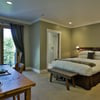

In [364]:
from PIL import Image
image_url = []
for i in range(0, len(df_hotel_best_5)):
    url = df_hotel_best_5['image_url'][i]
    image_url.append(str(url))
for image in image_url :
    link = cStringIO.StringIO(urllib.urlopen(image).read())
    img = Image.open(link) 
    img
    
#### how to show all img

In [365]:
#Best 5 hotel map
best_5_map(df_hotel_best_5, 'Hotels')

In [297]:
# Add Landmarks
df_landmarks_final = yelp_df("landmarks", "Distance")

/Users/stephanie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [298]:
#Add Nightlife
df_nightlife_final = yelp_df("nightlife", "Distance")

/Users/stephanie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [253]:
#get the most frequent category labels (Overall)
count_df = freq_cat(df_landmarks_final)

#plot
data = [go.Bar(x= count_df[0],y= count_df[1],
        marker=dict(
            color=['rgba(222,45,38,0.8)', 'grey', 'grey', 'grey', 'grey', 'grey',
                   'grey', 'grey','grey', 'grey',]))]
layout = go.Layout(title='Top 10 most frequent category for Landmarks')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Top 10 most frequent category3')

In [75]:
import json, ast
import pandas as pd
from django.utils.encoding import smart_str, smart_unicode
import re

In [68]:
def modify(city):
    """
    modify the input
    
    Argument: city
    
    Return: soup from the url link
    """
    # capitalize the first letter of each word in a string
    city = city.title()
    # replace the empty space with the _
    city = city.strip().replace(' ', '_')
    url = "https://en.wikipedia.org/wiki/" + str(city) +",_California"
    info = requests.get(url).content
    wikisoup = BeautifulSoup(info, 'lxml')
    return wikisoup

In [69]:
def extract_overview(city):
    """
    extract a brief overview from the wikipedia page
    
    Argument: city
    
    Return: print the overview description
    """
    wikisoup = modify(city)
    content = wikisoup.findAll("p")
    brief = content[0].text
    brief = ast.literal_eval(json.dumps(brief))
    print brief

In [182]:
def extract_info(city):
    """
    extract the basic information of the city
    
    Argument: city
    
    Return: a dataframe with the basic information
    """
    wikisoup = modify(city)
    data1 = wikisoup.findAll("tr", {"class": "mergedrow"})
    data = [dat.text for dat in data1]
    split = [dat.strip("\n") for dat in data]
    pd_info = pd.DataFrame(split)
    pd_info.rename(columns = {list(pd_info)[0]: 'info'}, inplace = True)

    #remove []
    pd_info['info'] = pd_info['info'].map(lambda x: re.sub("(\[).*?([\]])", "", x))
    #remove unwanted characters
    pd_info['info'] = pd_info['info'].map(lambda x: re.sub(ur'[\•]', ' ', x))
    pd_info['info'] = pd_info['info'].str.strip("\n")
    # how to only get one colon
    pd_info['info'] = pd_info['info'].str.replace("\n", " : ")
    return pd_info

In [77]:
output = extract_overview("San Francisco")
# how to change the \u2013
output

California


In [78]:
city = "San Francisco"
wikisoup = modify(city)
content = wikisoup.findAll("p")
#print content[0:1].text

In [79]:
brief = content[0].text
brief = ast.literal_eval(json.dumps(brief))

In [183]:
extract_info("san francisco")

,info
0,"Motto: Oro en Paz, Fierro en Guerra (Spanish) ..."
1,State : : California
2,CSA : San Jose–San Francisco–Oakland
3,Metro : San Francisco–Oakland–Hayward
4,"Incorporated : April 15, 1850"
5,Founded by : José Joaquin Moraga : Francisco P...
6,Named for : St. Francis of Assisi
7,Type : Mayor-council
8,Body : Board of Supervisors
9,Mayor : Edwin M. Lee (D)


In [184]:
from IPython.display import display
from ipywidgets import widgets

inputText = widgets.Text()

def modify_input(sender):
    outputText.value = "Welcome to The City of " + inputText.value.title() + "!"

inputText.on_submit(modify_input)
inputText


In [185]:
outputText = widgets.Text()
outputText

### Here is a brief overview of the city.

In [186]:
extract_overview("San Francisco")

California


In [188]:
def ask_input():
    city = raw_input("Please enter the city that you want to visit: ")
    print "\nWelcome to The City of", city.title(),"\n\nHere is a brief overview of the city:\n"
    input_city = city.title()
    overview = extract_overview(input_city)
    info = extract_info(input_city)
    print overview
    return info

In [192]:
ask_input()

Please enter the city that you want to visit: Davis

Welcome to The City of Davis 

Here is a brief overview of the city:

Davis is a city in the U.S. state of California and the most populous city in Yolo County. It had a population of 65,622 in 2010,[9] not including the on-campus population of the University of California, Davis, which was 32,153 in 2009.
None


,info
0,State : California
1,County : Yolo
2,"Incorporated : March 28, 1917"
3,Mayor : Robb Davis
4,State senator : Bill Dodd (D)
5,Assemblymember : Cecilia Aguiar-Curry (D)
6,U.S. rep. : John Garamendi (D)
7,Total : 9.919 sq mi (25.690 km2)
8,Land : 9.887 sq mi (25.608 km2)
9,Water : 0.032 sq mi (0.082 km2) 0.32%
